При работе с FLAML столкнулась с проблемой в виде того, что он не совместим с последними версиями многих библиотек. Вот небольшая подборка версий библиотек для успешной работы с FLAML:
numpy==1.23.5
scipy==1.10.1
scikit-learn==1.3.0
lightgbm==4.0.0
xgboost==1.7.6
flaml==2.1.2
pandas==2.0.3
matplotlib==3.7.2
seaborn==0.12.2

In [1]:
#!pip install numpy==1.23.5 scipy==1.10.1 scikit-learn==1.3.0 lightgbm==4.0.0 xgboost==1.7.6 flaml==2.1.2 pandas==2.0.3 matplotlib==3.7.2 seaborn==0.12.2
#!pip install xgboost==2.0.3

In [8]:
import re
import warnings
from datetime import datetime
from collections import defaultdict
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, roc_auc_score, confusion_matrix,
    roc_curve)
from flaml import AutoML
import catboost
import sys
import subprocess

warnings.filterwarnings('ignore')

## Подготовка данных

Значения столбцов таблицы res_diag:
    
Данные о пациентах

PTID - Participant ID - уникальный идентификатор пациента

IMAGEUID - Image Unique ID - уникальный идентификатор изображения MRI

EXAMDATE - Examination Date - дата проведения обследования

SITE - Site ID - идентификатор исследовательского центра

AGE - Age at baseline - возраст на момент включения в исследование

PTGENDER - Participant Gender - пол пациента

PTEDUCAT - Participant Education - годы образования

PTETHCAT - Participant Ethnic Category - этническая принадлежность

PTRACCAT - Participant Race Category - расовая принадлежность

PTMARRY - Participant Marital Status - семейное положение

APOE4 - APOE ε4 allele carrier status - статус носительства аллеля APOE4 (фактор риска болезни Альцгеймера)

Month и M - Months from baseline - месяцы от момента включения в исследование


Клинические и нейропсихологические тесты:
    
CDRSB - общий балл по шкале оценки деменции

ADAS11 - шкала оценки болезни Альцгеймера (11 пунктов)

ADAS13 - шкала оценки болезни Альцгеймера (13 пунктов)

ADASQ4 - тест на запоминание слов из ADAS

MMSE - краткая шкала оценки психического статуса

RAVLT_immediate - немедленное воспроизведение

RAVLT_learning - обучение/запоминание

RAVLT_forgetting - забывание

RAVLT_perc_forgetting - процент забывания

LDELTOTAL - отсроченное воспроизведение логической памяти

LDELTOTAL_BL - базовый уровень отсроченного воспроизведения

TRABSCOR -  тест следования связям (часть B)

FAQ - опросник функциональной активности

mPACCdigit - модифицированный доклинический когнитивный композит 

mPACCtrailsB - модифицированный доклинический когнитивный композит (следование связям B)

    
Метрики по областям мозга
    
Столбцы начинающиеся с ST - это объемы конкретных регионов мозга после сегментации:

ST...SV - Subcortical Volume (подкорковый объем)

ST...CV - Cortical Volume (корковый объем)

ST...SA - Surface Area (площадь поверхности)

ST...TA - Total Area (общая площадь)

ST...TS - Thickness (толщина коры)

Где ... - номер региона по FreeSurfer. 

Например:

ST101SV - Left Thalamus volume (левый таламус)


Основные подкорковые структуры (+ SV - Subcortical Volume)


ST101SV - Left Thalamus (левый таламус)

ST102SV - Left Caudate (левое хвостатое ядро)

ST103SV - Left Putamen (левая скорлупа)

ST104SV - Left Pallidum (левый бледный шар)

ST105SV - Left Hippocampus (левый гиппокамп)

ST107SV - Left Accumbens area (левая прилежащая область)

ST108SV - Left Ventral DC (левый вентральный диэнцефалон)

ST109SV - Right Thalamus (правый таламус)

ST110SV - Right Caudate (правое хвостатое ядро)

ST111SV - Right Putamen (правая скорлупа)

ST112SV - Right Pallidum (правый бледный шар)

ST113SV - Right Hippocampus (правый гиппокамп)

ST114SV - Right Amygdala (правое миндалевидное тело)

ST115SV - Right Accumbens area (правая прилежащая область)

ST116SV - Right Ventral DC (правый вентральный диэнцефалон)

Корковые регионы (+ CV - Cortical Volume, SA - Surface Area, TA - Thickness)


Лобная доля (Frontal Lobe)


  ST23 - Left Superior Frontal (левая верхняя лобная извилина)
  
  ST24 - Left Rostral Middle Frontal (левая ростральная средняя лобная)
  
  ST25 - Left Caudal Middle Frontal (левая каудальная средняя лобная)
  
  ST26 - Left Precentral (левая прецентральная извилина)
  
  ST31 - Left Pars Opercularis (левая покрышечная часть)
  
  ST32 - Left Pars Triangularis (левая треугольная часть)
  
  ST34 - Left Lateral Orbitofrontal (левая латеральная орбитофронтальная)
  
  ST35 - Left Medial Orbitofrontal (левая медиальная орбитофронтальная)
  
  ST38 - Left Frontal Pole (левый лобный полюс)
  

Височная доля (Temporal Lobe)


  ST13 - Left Entorhinal (левая энторинальная кора)
  
  ST14 - Left Fusiform (левая веретенообразная извилина)
  
  ST15 - Left Inferior Temporal (левая нижняя височная извилина)
  
  ST39 - Left Middle Temporal (левая средняя височная извилина)
  
  ST40 - Left Superior Temporal (левая верхняя височная извилина)
  
  ST43 - Left Banks STS (левый банк верхней височной борозды)
  
  ST44 - Left Transverse Temporal (левая поперечная височная извилина)
  
  ST45 - Left Temporal Pole (левый височный полюс)
  

Теменная доля (Parietal Lobe)


  ST46 - Left Inferior Parietal (левая нижняя теменная доля)
  
  ST47 - Left Superior Parietal (левая верхняя теменная доля)
  
  ST48 - Left Postcentral (левая постцентральная извилина)
  
  ST49 - Left Supramarginal (левая надкраевая извилина)
  
  ST54 - Left Precuneus (левая предклиньевая извилина)
  

Затылочная доля (Occipital Lobe)


  ST55 - Left Lateral Occipital (левая латеральная затылочная)
  
  ST56 - Left Lingual (левая язычная извилина)
  
  ST57 - Left Cuneus (левая клиновидная извилина)
  
  ST58 - Left Pericalcarine (левая околошпорная кора)
  

Другие важные регионы


  ST59 - Left Insula (левый островок)
  
  ST60 - Left Cingulate (левая поясная извилина)

In [9]:
df = pd.read_csv("res_diag.csv")

In [10]:
def prepare_adni_data_complete(df):
    #обработка категориальных признаков
    df_prepared = df.copy()
    ordinal_features = {
        'OVERALLQC': {
            'Pass': 3,
            'Partial': 2,
            'Hippocampus Only': 1,
            'Fail': 0},
        'TEMPQC': {'Pass': 1, 'Fail': 0},
        'FRONTQC': {'Pass': 1, 'Fail': 0},
        'PARQC': {'Pass': 1, 'Fail': 0},
        'INSULAQC': {'Pass': 1, 'Fail': 0},
        'OCCQC': {'Pass': 1, 'Fail': 0},
        'BGQC': {'Pass': 1, 'Fail': 0},
        'CWMQC': {'Pass': 1, 'Fail': 0},
        'VENTQC': {'Pass': 1, 'Fail': 0},
        'HIPPOQC': {'Pass': 1, 'Fail': 0},
        'DX': {'CN': 0, 'MCI': 1, 'Dementia': 2} }
    
    for col, mapping in ordinal_features.items():
        if col in df_prepared.columns:
            df_prepared[col] = df_prepared[col].map(mapping)
            median_val = df_prepared[col].median()
            df_prepared[col] = df_prepared[col].fillna(median_val)
    binary_features = {'PTGENDER': {'Female': 0, 'Male': 1},}
    
    for col, mapping in binary_features.items():
        if col in df_prepared.columns:
            df_prepared[col] = df_prepared[col].map(mapping)

    nominal_features = ['PTETHCAT', 'PTRACCAT', 'PTMARRY']
    
    for col in nominal_features:
        if col in df_prepared.columns:
            if df_prepared[col].isna().any():
                mode_val = df_prepared[col].mode()[0] if not df_prepared[col].mode().empty else 'Unknown'
                df_prepared[col] = df_prepared[col].fillna(mode_val)
            
            freq = df_prepared[col].value_counts(normalize=True)
            df_prepared[f'{col}_FREQ'] = df_prepared[col].map(freq)
    
    small_cardinality_numeric = ['PTEDUCAT', 'APOE4', 'ADASQ4']
    
    for col in small_cardinality_numeric:
        if col in df_prepared.columns:
            if df_prepared[col].isna().any():
                median_val = df_prepared[col].median()
                df_prepared[col] = df_prepared[col].fillna(median_val)
#обработка дат      
    if 'EXAMDATE' in df_prepared.columns:
        try:
            df_prepared['EXAMDATE'] = pd.to_datetime(df_prepared['EXAMDATE'])
            df_prepared['EXAM_YEAR'] = df_prepared['EXAMDATE'].dt.year
            df_prepared['EXAM_MONTH'] = df_prepared['EXAMDATE'].dt.month
            df_prepared['EXAM_DAY'] = df_prepared['EXAMDATE'].dt.day
            df_prepared['EXAM_DAYOFWEEK'] = df_prepared['EXAMDATE'].dt.dayofweek
            df_prepared['EXAM_QUARTER'] = df_prepared['EXAMDATE'].dt.quarter
            df_prepared['EXAM_DAYOFYEAR'] = df_prepared['EXAMDATE'].dt.dayofyear
            if 'EXAMDATE' in df_prepared.columns and 'EXAM_YEAR' in df_prepared.columns:
                min_year = df_prepared['EXAM_YEAR'].min()
                df_prepared['YEARS_FROM_START'] = df_prepared['EXAM_YEAR'] - min_year
        except Exception as e:
                print(ghfj)
    if 'Month' in df_prepared.columns:
        df_prepared['TIME_FROM_BASELINE'] = df_prepared['Month']
#обработка пропусков в когнитивных тестах
    cognitive_tests = [
        'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate',
        'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting',
        'LDELTOTAL', 'LDELTOTAL_BL', 'TRABSCOR', 'FAQ',
        'mPACCdigit', 'mPACCtrailsB', 'ADASQ4']
    
    for test in cognitive_tests:
        if test in df_prepared.columns:
            if df_prepared[test].isna().any():
                if 'AGE' in df_prepared.columns:
                    df_prepared['AGE_GROUP_10'] = (df_prepared['AGE'] // 10) * 10
                    df_prepared[test] = df_prepared.groupby('AGE_GROUP_10')[test].transform(
                        lambda x: x.fillna(x.median())
                    )
                df_prepared[test] = df_prepared[test].fillna(df_prepared[test].median())
    if 'AGE_GROUP_10' in df_prepared.columns:
        df_prepared = df_prepared.drop(columns=['AGE_GROUP_10'])
    
#обработка метрик мозговых структур
    volume_cols = [col for col in df_prepared.columns 
                  if 'ST' in str(col) and ('SV' in str(col) or 'CV' in str(col))]

#нормализация объемов
    if volume_cols:
        #ищем внутричерепной объем
        icv_candidates = ['ST1000SV', 'EstimatedTotalIntraCranialVol', 'ICV']
        icv_col = None
        for candidate in icv_candidates:
            if candidate in df_prepared.columns:
                icv_col = candidate
                break
        
        #если не нашли, создаем как сумму всех объемов
        if not icv_col and len(volume_cols) > 10:
            icv_col = 'ESTIMATED_ICV'
            df_prepared[icv_col] = df_prepared[volume_cols].sum(axis=1)
            volume_cols.append(icv_col)
        
        if icv_col:
            for col in volume_cols:
                if col != icv_col and icv_col in df_prepared.columns:
                    df_prepared[f'{col}_NORM'] = df_prepared[col] / df_prepared[icv_col]
    
    #асимметрия мозга
    left_right_pairs = [
        ('ST105SV', 'ST113SV'),  # Hippocampus - САМЫЙ ВАЖНЫЙ ДЛЯ AD!
        ('ST101SV', 'ST109SV'),  # Thalamus
        ('ST102SV', 'ST110SV'),  # Caudate
    ]
    
    for left, right in left_right_pairs:
        if left in df_prepared.columns and right in df_prepared.columns:
            #асимметрия (L-R)/(L+R) - положительное = левый больше
            df_prepared[f'ASYMM_{left}_{right}'] = (
                (df_prepared[left] - df_prepared[right]) / 
                (df_prepared[left] + df_prepared[right] + 1e-10)
            )
            #отношение
            df_prepared[f'RATIO_{left}_{right}'] = (
                df_prepared[left] / (df_prepared[right] + 1e-10)
            )
    
    
    #удаление константных столбцов
    for col in df_prepared.columns:
        if df_prepared[col].nunique() <= 1:
            df_prepared = df_prepared.drop(columns=[col])
    
    #удаление столбцов с большим процентом пропусков (>30%)
    for col in df_prepared.columns:
        null_pct = df_prepared[col].isna().sum() / len(df_prepared)
        if null_pct > 0.3:
            df_prepared = df_prepared.drop(columns=[col])
    
    #заполнение оставшихся пропусков
    for col in df_prepared.columns:
        if df_prepared[col].isna().any():
            if df_prepared[col].dtype in ['int64', 'float64']:
                df_prepared[col] = df_prepared[col].fillna(df_prepared[col].median())
            else:
                df_prepared[col] = df_prepared[col].fillna(df_prepared[col].mode()[0])
    return df_prepared

In [11]:
def encode_for_flaml(df):
#всё еще обработка категориальных признаков 
    df_encoded = df.copy()
    nominal_to_onehot = ['PTETHCAT', 'PTRACCAT', 'PTMARRY']
    
    for col in nominal_to_onehot:
        if col in df_encoded.columns:
            top_n = min(5, df_encoded[col].nunique())
            top_categories = df_encoded[col].value_counts().nlargest(top_n).index
            
            for category in top_categories:
                df_encoded[f'{col}_{category}'] = (df_encoded[col] == category).astype(int)
            
            df_encoded = df_encoded.drop(columns=[col])

    object_cols = df_encoded.select_dtypes(include=['object']).columns
    for col in object_cols:
        df_encoded[col] = df_encoded[col].astype(str)
    
    return df_encoded

In [12]:
def clean_column_names(df):
#изменение названий столбцов
    df_clean = df.copy()
    
    new_columns = {}
    for col in df_clean.columns:
        col_str = str(col)
        col_str = ''.join(char for char in col_str if ord(char) < 128)
        col_str = re.sub(r'[^a-zA-Z0-9_]', '_', col_str)
        col_str = re.sub(r'_+', '_', col_str)
        col_str = col_str.strip('_')
        if not col_str:
            col_str = f'feature_{hash(col) % 10000}'
        
        col_str = col_str.lower()

        if len(col_str) > 50:
            col_str = col_str[:50]
        
        new_columns[col] = col_str
    
    df_clean = df_clean.rename(columns=new_columns)
    
    if len(df_clean.columns) != len(set(df_clean.columns)):
        seen = {}
        new_cols = []
        for col in df_clean.columns:
            if col in seen:
                seen[col] += 1
                new_cols.append(f"{col}_{seen[col]}")
            else:
                seen[col] = 1
                new_cols.append(col)
        df_clean.columns = new_cols
    return df_clean

In [13]:
def clean_feature_names_thorough(df):
    df_clean = df.copy()
    problematic = r'[\[\]\{\},:"\'\\\/\|\?\*\<\>\s\t\n\r\0\x0B]'
    new_columns = {}
    for idx, col in enumerate(df_clean.columns):
        if not isinstance(col, str):
            col = str(col)
        cleaned = re.sub(problematic, '_', col)
        cleaned = re.sub(r'_+', '_', cleaned)
        cleaned = cleaned.strip('_')
        if not cleaned:
            cleaned = f'feature_{idx}'
        if len(cleaned) > 255:
            cleaned = cleaned[:255]
        cleaned = cleaned.replace('.', '_')
        new_columns[col] = cleaned
    df_clean = df_clean.rename(columns=new_columns)
    if len(df_clean.columns) != len(set(df_clean.columns)):
        df_clean.columns = [f"{col}_{i}" if list(df_clean.columns).count(col) > 1 else col 
                           for i, col in enumerate(df_clean.columns)]
    return df_clean

In [14]:
def complete_prep(df):
    df1 = prepare_adni_data_complete(df)
    df2 = encode_for_flaml(df1)
    df3 = clean_column_names(df2)
    df4 = clean_feature_names_thorough(df3)
    return df4

In [15]:
df = complete_prep(df)

## Предсказание MMSE

In [90]:
def predict_mmse_robust(df, time_horizon=12):
    df_work = df.copy()
    mmse_columns = [col for col in df_work.columns if 'mmse' in col.lower()]
    mmse_col = mmse_columns[0]
    initial_len = len(df_work)
    df_work = df_work.dropna(subset=[mmse_col])
    id_columns = [col for col in df_work.columns 
                 if 'ptid' in col.lower() or 'participant' in col.lower() or 'id' in col.lower()]
    patient_id_col = id_columns[0] if id_columns else None
    
    time_columns = [col for col in df_work.columns 
                   if 'month' in col.lower() or 'time' in col.lower()]
    time_col = time_columns[0] if time_columns else None
    
    if patient_id_col and time_col:
        df_work = df_work.sort_values([patient_id_col, time_col])
        df_work['MMSE_FUTURE'] = df_work.groupby(patient_id_col)[mmse_col].shift(-1)
    else:
        df_work['MMSE_FUTURE'] = df_work[mmse_col]
    
    df_work = df_work.dropna(subset=['MMSE_FUTURE'])
    
    exclude_cols = []
    if patient_id_col:
        exclude_cols.append(patient_id_col)
    if time_col:
        exclude_cols.append(time_col)
    
    exclude_cols.extend(['MMSE_FUTURE', mmse_col])
    other_id_like = [col for col in df_work.columns 
                    if 'uid' in col.lower() or 'date' in col.lower() or 'exam' in col.lower()]
    exclude_cols.extend(other_id_like)
    exclude_cols = list(set(exclude_cols))
    
    numeric_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    X = df_work[feature_cols].reset_index(drop=True)
    y = df_work['MMSE_FUTURE'].reset_index(drop=True)
    
    X_filled = X.copy()
    for col in X_filled.columns:
        if X_filled[col].isna().any():
            X_filled[col] = X_filled[col].fillna(X_filled[col].median())
    
    try:
        y_bins = pd.qcut(y, q=4, labels=False, duplicates='drop')
        X_train, X_test, y_train, y_test = train_test_split(
            X_filled, y, test_size=0.2, stratify=y_bins, random_state=42
        )
    except:
        X_train, X_test, y_train, y_test = train_test_split(
            X_filled, y, test_size=0.2, random_state=42
        )
    
    automl = AutoML()
    
    automl.fit(
        X_train=X_train,
        y_train=y_train,
        time_budget=120,
        task='regression',
        metric='rmse',
        estimator_list=['lgbm', 'rf', 'xgboost'],
        eval_method='cv',
        n_splits=3,
        early_stop=True,
        verbose=0)
    
    y_pred = automl.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Лучшая модель: {automl.best_estimator}")
    print(f"Качество R²: {r2:.3f}")
    print(f"Ошибка MAE: {mae:.3f} балла")
    
    if hasattr(automl.model, 'feature_importances_'):
        importances = automl.model.feature_importances_
        feat_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("Три ключевых предиктора:")
        for i, row in feat_importance.head(3).iterrows():
            print(f"  {row['feature']}: {row['importance']:.3f}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, s=30)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('Реальное MMSE')
    plt.ylabel('Предсказанное MMSE')
    plt.title(f'Прогноз MMSE (R²={r2:.3f})')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'automl': automl,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'metrics': {'rmse': rmse, 'mae': mae, 'r2': r2}
    }

Прогноз MMSE...
Лучшая модель: lgbm
Качество R²: 0.698
Ошибка MAE: 1.544 балла
Три ключевых предиктора:
  mpacctrailsb: 34.000
  adas13: 27.000
  mpaccdigit: 15.000


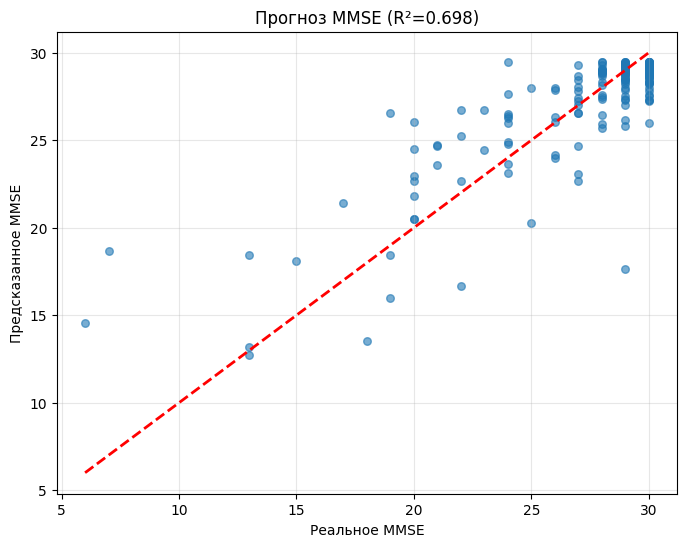

In [91]:
X = df
results = predict_mmse_robust(X, time_horizon=12)

## Вывод: 
Качество модели хорошее (R²=0.68), так как объяснеется 70% изменчивости MMSE. Основными предикторами оказались другие когнитивные тесты: mpacctrailsb (тест на внимание), adas13 (когнитивный тест) и mpaccdigit (когнитивный тест). Лучшая модель по итогу работы FLAML явлется lgbm. График также визуализирует, что данная модель хорошо описывает данные.

## Создаем данные для прогнозирования переходов от CN к MCI и от MCI к AD

In [101]:
def find_key_columns(df):
    dx_col = next((col for col in df.columns if 'dx' in str(col).lower() and 'change' not in str(col).lower()), None)
    
    if not dx_col:
        for col in df.columns:
            if df[col].dtype in ['int64', 'float64'] and df[col].nunique() <= 5:
                if set(df[col].dropna().unique()).issubset({1, 2, 3}):
                    dx_col = col
                    break
    
    patient_col = next((col for col in df.columns if 'ptid' in str(col).lower()), None)
    if not patient_col:
        patient_col = next((col for col in df.columns if 'patient' in str(col).lower()), None)
    if not patient_col:
        df['_TEMP_PTID'] = range(len(df))
        patient_col = '_TEMP_PTID'
    
    time_col = next((col for col in df.columns if 'month' in str(col).lower()), None)
    if not time_col:
        time_col = next((col for col in df.columns if 'time' in str(col).lower()), None)
    if not time_col:
        df['_TEMP_VISIT_ORDER'] = df.groupby(patient_col).cumcount()
        time_col = '_TEMP_VISIT_ORDER'
    
    return dx_col, patient_col, time_col

In [102]:
def create_basic_dynamics(df, dx_col, patient_col, time_col):
    df_work = df.sort_values([patient_col, time_col])
    
    df_work['DX_CHANGE'] = df_work.groupby(patient_col)[dx_col].diff()
    df_work['DX_PROGRESSION'] = 0
    df_work.loc[df_work['DX_CHANGE'] > 0, 'DX_PROGRESSION'] = 1
    df_work.loc[df_work['DX_CHANGE'] < 0, 'DX_PROGRESSION'] = -1
    
    def categorize_change(row):
        dx_change = row['DX_CHANGE']
        dx_current = row[dx_col]
        
        if pd.isna(dx_change):
            return 'first_visit'
        if dx_change == 0:
            return 'stable'
        if dx_change == 1:
            return 'cn_to_mci' if dx_current == 2 else 'mci_to_ad' if dx_current == 3 else 'progression_1_step'
        if dx_change == 2:
            return 'cn_to_ad'
        if dx_change > 2:
            return 'rapid_progression'
        if dx_change == -1:
            return 'mci_to_cn' if dx_current == 1 else 'ad_to_mci' if dx_current == 2 else 'improvement_1_step'
        if dx_change < -1:
            return 'significant_improvement'
        return f'change_{int(dx_change)}'
    
    df_work['DX_CHANGE_CATEGORY'] = df_work.apply(categorize_change, axis=1)
    df_work['HAS_PROGRESSED'] = (df_work['DX_CHANGE'] > 0).astype(int)
    df_work['PROGRESSED_TO_AD'] = ((df_work[dx_col] == 3) & (df_work.groupby(patient_col)[dx_col].shift(1) < 3)).astype(int)
    
    return df_work

In [103]:
def create_aggregated_features(df_work, dx_col, patient_col, time_col):
    try:
        patient_stats = df_work.groupby(patient_col).agg({
            dx_col: ['first', 'last'],
            'DX_CHANGE': ['sum', lambda x: (x > 0).sum()],
            time_col: ['min', 'max']
        })
        
        patient_stats.columns = ['DX_FIRST', 'DX_LAST', 'DX_TOTAL_CHANGE', 'DX_PROGRESSION_COUNT', 'TIME_FIRST', 'TIME_LAST']
        
        patient_stats['DX_FINAL_CHANGE'] = patient_stats['DX_LAST'] - patient_stats['DX_FIRST']
        patient_stats['HAS_ANY_PROGRESSION'] = (patient_stats['DX_PROGRESSION_COUNT'] > 0).astype(int)
        patient_stats['PROGRESSED_TO_AD_EVER'] = (patient_stats['DX_LAST'] == 3).astype(int)
        
        if pd.api.types.is_numeric_dtype(patient_stats['TIME_FIRST']):
            patient_stats['TIME_SPAN'] = patient_stats['TIME_LAST'] - patient_stats['TIME_FIRST']
            patient_stats['PROGRESSION_RATE'] = np.where(
                patient_stats['TIME_SPAN'] > 0,
                patient_stats['DX_TOTAL_CHANGE'] / patient_stats['TIME_SPAN'],
                np.nan
            )
        
        patient_stats = patient_stats.reset_index()
        df_work = df_work.merge(patient_stats, on=patient_col, how='left')
        
        df_work['DX_SINCE_BASELINE'] = df_work[dx_col] - df_work['DX_FIRST']
        
        return df_work
        
    except Exception:
        return df_work

In [104]:
def clean_temp_columns(df_work):
    cols_to_drop = [col for col in df_work.columns if '_TEMP_' in str(col)]
    if cols_to_drop:
        df_work = df_work.drop(columns=cols_to_drop)
    return df_work

In [105]:
def create_diagnosis_dynamics_features(df):
    df_work = df.copy()
    
    dx_col, patient_col, time_col = find_key_columns(df_work)
    if not dx_col:
        return df_work
    
    df_work = create_basic_dynamics(df_work, dx_col, patient_col, time_col)
    df_work = create_aggregated_features(df_work, dx_col, patient_col, time_col)
    df_work = clean_temp_columns(df_work)
    
    return df_work

In [106]:
def create_progression_target(df):
    if 'ptid' in df.columns and 'HAS_PROGRESSED' in df.columns:
        df['TARGET_PROGRESSION_NEXT_VISIT'] = df.groupby('ptid')['HAS_PROGRESSED'].shift(-1)
    return df

In [107]:
def process_diagnosis_dynamics(df):
    df_with_dynamics = create_diagnosis_dynamics_features(df)
    df_with_dynamics = create_progression_target(df_with_dynamics)
    return df_with_dynamics

In [108]:
df_with_dynamics = process_diagnosis_dynamics(df_clean)

## Прогнозирования переходов от CN к MCI и от MCI к AD

In [113]:
def merge_data(df_dynamics, df_features):
    if 'ptid' in df_dynamics.columns and 'ptid' in df_features.columns:
        return pd.merge(df_dynamics, df_features, on='ptid', suffixes=('_dyn', '_feat'))
    else:
        return pd.concat([df_dynamics, df_features], axis=1)

In [114]:
def analyze_improvements(df):
    if 'DX_CHANGE' not in df.columns:
        return None, 0
    
    improvement_cases = df[df['DX_CHANGE'] < 0]
    return improvement_cases, len(improvement_cases)

In [115]:
def predict_target(df, target_col, problem_type='classification'):
    if target_col not in df.columns:
        return None
    
    data = df.dropna(subset=[target_col])
    if len(data) < 50:
        return None
    
    exclude_patterns = ['ptid', 'imageuid', 'examdate', 'visit', 'month', target_col]
    feature_cols = []
    
    for col in data.columns:
        col_lower = str(col).lower()
        exclude = any(p in col_lower for p in exclude_patterns)
        if not exclude and pd.api.types.is_numeric_dtype(data[col]) and data[col].nunique() > 1:
            feature_cols.append(col)
    
    if len(feature_cols) > 100:
        variances = data[feature_cols].var()
        feature_cols = variances.nlargest(100).index.tolist()
    
    X = data[feature_cols].fillna(data[feature_cols].median())
    y = data[target_col]
    
    if problem_type == 'classification':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    automl = AutoML()
    settings = {
        'time_budget': 120,
        'metric': 'roc_auc' if problem_type == 'classification' and y.nunique() == 2 else 'rmse',
        'task': problem_type,
        'estimator_list': ['lgbm', 'xgboost', 'rf'],
        'eval_method': 'cv',
        'n_splits': 3,
        'verbose': 0
    }
    
    automl.fit(X_train=X_train, y_train=y_train, **settings)
    
    if problem_type == 'classification':
        y_pred_proba = automl.predict_proba(X_test)[:, 1] if y.nunique() == 2 else automl.predict_proba(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int) if y.nunique() == 2 else automl.predict(X_test)
    else:
        y_pred = automl.predict(X_test)
    
    if problem_type == 'classification':
        accuracy = accuracy_score(y_test, y_pred)
        metrics = {'accuracy': accuracy}
        if y.nunique() == 2:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            metrics['roc_auc'] = roc_auc
    else:
        metrics = {
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred)
        }
        
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.6, s=30)
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        plt.xlabel('Реальные значения')
        plt.ylabel('Предсказанные значения')
        plt.title(f'{target_col} (R²={metrics["r2"]:.3f})')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return {
        'automl': automl,
        'metrics': metrics,
        'model': automl.best_estimator
    }

In [116]:
def run_predictions(df):
    priority_targets = []
    
    for target in ['HAS_PROGRESSED', 'PROGRESSED_TO_AD', 'IS_STABLE']:
        if target in df.columns:
            priority_targets.append((target, 'classification'))
    
    for target in ['DX_CHANGE', 'PROGRESSION_RATE', 'DX_SINCE_BASELINE']:
        if target in df.columns and df[target].nunique() > 10:
            priority_targets.append((target, 'regression'))
    
    results = {}
    for target, problem_type in priority_targets:
        result = predict_target(df, target, problem_type)
        if result:
            results[target] = result
    
    return results

In [117]:
def create_summary(results):
    if not results:
        return None
    
    summary_data = []
    for target, result in results.items():
        if 'metrics' in result:
            metrics = result['metrics']
            if 'accuracy' in metrics:
                summary_data.append({
                    'Таргет': target,
                    'Тип': 'Классификация',
                    'Accuracy': f"{metrics['accuracy']:.3f}",
                    'Модель': result['model']
                })
            else:
                summary_data.append({
                    'Таргет': target,
                    'Тип': 'Регрессия',
                    'R²': f"{metrics['r2']:.3f}",
                    'Модель': result['model']
                })
    
    return pd.DataFrame(summary_data)

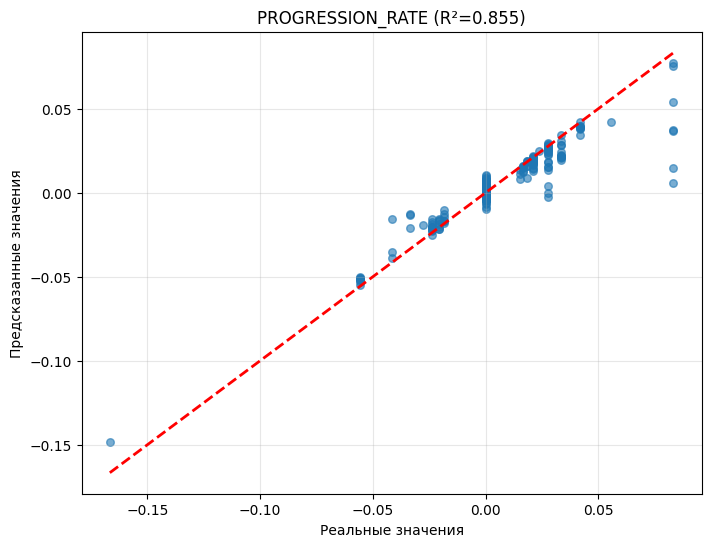

          Таргет           Тип Accuracy Модель    R²
  HAS_PROGRESSED Классификация    0.993   lgbm   NaN
PROGRESSED_TO_AD Классификация    1.000   lgbm   NaN
PROGRESSION_RATE     Регрессия      NaN   lgbm 0.855


In [118]:
def analyze_dynamics(df_dynamics, df_features):
    df_combined = merge_data(df_dynamics, df_features)
    
    improvement_cases, improvement_count = analyze_improvements(df_combined)
    
    if improvement_count > 20 and 'HAS_IMPROVED' in df_combined.columns:
        df_combined['TARGET_IMPROVEMENT'] = (df_combined['DX_CHANGE'] < 0).astype(int)
    
    results = run_predictions(df_combined)
    summary = create_summary(results)
    
    return df_combined, results, summary

df_combined, results, summary = analyze_dynamics(df_with_dynamics, df_clean)

if summary is not None:
    print(summary.to_string(index=False))

## Вывод: 
В качестве таргетных признаков были следующие: прогрессия (HAS_PROGRESSED), конверсия в AD (PROGRESSED_TO_AD) и скорость прогрессии (PROGRESSION_RATE). Для первых двух признаков мы использовали классификацию, для последнего - регрессию. Для всех трех задач наилучшей моделью оказалась LGBM, которая дала очень высокие метрики. График показал, что модель lgbm хорошо предсказывает реальные значения скорости развития болезни.

## Предсказание изменение объемов гиппокампа

In [18]:
def predict_hippocampus_changes(df):
    # Создание целевых переменных
    df_work = df.copy()
    time_col = next((col for col in df.columns if 'month' in str(col).lower()), None)
    patient_col = next((col for col in df.columns if 'ptid' in str(col).lower()), None)
    
    has_temporal_data = time_col and patient_col and 'st105cv' in df.columns and 'st113cv' in df.columns
    
    if has_temporal_data:
        df_work = df_work.sort_values([patient_col, time_col])
        df_work['LEFT_HIPP_CHANGE'] = df_work.groupby(patient_col)['st105cv'].diff()
        df_work['RIGHT_HIPP_CHANGE'] = df_work.groupby(patient_col)['st113cv'].diff()
        df_work['TOTAL_HIPP_VOL'] = df_work['st105cv'] + df_work['st113cv']
        df_work['TOTAL_HIPP_CHANGE'] = df_work.groupby(patient_col)['TOTAL_HIPP_VOL'].diff()
        df_work['TIME_DIFF'] = df_work.groupby(patient_col)[time_col].diff()
        df_work['LEFT_HIPP_RATE'] = df_work['LEFT_HIPP_CHANGE'] / df_work['TIME_DIFF']
        df_work['RIGHT_HIPP_RATE'] = df_work['RIGHT_HIPP_CHANGE'] / df_work['TIME_DIFF']
        df_work['TOTAL_HIPP_RATE'] = df_work['TOTAL_HIPP_CHANGE'] / df_work['TIME_DIFF']
        df_work = df_work.dropna(subset=['LEFT_HIPP_CHANGE', 'RIGHT_HIPP_CHANGE', 'TOTAL_HIPP_CHANGE'])
        targets = ['LEFT_HIPP_CHANGE', 'RIGHT_HIPP_CHANGE', 'TOTAL_HIPP_CHANGE', 
                  'LEFT_HIPP_RATE', 'RIGHT_HIPP_RATE', 'TOTAL_HIPP_RATE']
    else:
        df_work['TOTAL_HIPP_VOL'] = df_work['st105cv'] + df_work['st113cv']
        df_work['HIPPO_ASYMMETRY'] = (df_work['st105cv'] - df_work['st113cv']) / (df_work['st105cv'] + df_work['st113cv'])
        targets = ['st105cv', 'st113cv', 'TOTAL_HIPP_VOL', 'HIPPO_ASYMMETRY']
    
    targets = [t for t in targets if t in df_work.columns]
    exclude_patterns = ['ptid', 'imageuid', 'examdate', 'visit', 'month', 'time', 'change', 'rate', 'diff']
    all_features = []
    for col in df_work.columns:
        col_lower = str(col).lower()
        exclude = any(pattern in col_lower for pattern in exclude_patterns)
        if not exclude and col not in targets and pd.api.types.is_numeric_dtype(df_work[col]):
            if df_work[col].nunique() > 1 and df_work[col].notna().sum() > len(df_work) * 0.5:
                all_features.append(col)
    
    if len(all_features) > 200:
        variances = df_work[all_features].var()
        all_features = variances.nlargest(200).index.tolist()
    
    results = {}
    for target in targets:
        data = df_work.copy()
        data = data.dropna(subset=[target])
        if len(data) < 100:
            continue
        
        X = data[all_features].fillna(data[all_features].median())
        y = data[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        automl = AutoML()
        settings = {
            'time_budget': 180,
            'metric': 'rmse',
            'task': 'regression',
            'estimator_list': ['lgbm', 'xgboost', 'rf', 'extra_tree'],
            'eval_method': 'cv',
            'n_splits': 3,
            'early_stop': True,
            'verbose': 0
        }
        
        try:
            automl.fit(X_train=X_train, y_train=y_train, **settings)
        except:
            continue
        
        y_pred = automl.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        feature_importance = None
        if hasattr(automl.model.estimator, 'feature_importances_'):
            importances = automl.model.estimator.feature_importances_
            feature_importance = pd.DataFrame({
                'feature': all_features,
                'importance': importances
            }).sort_values('importance', ascending=False)
        
        results[target] = {
            'automl': automl,
            'metrics': {'rmse': rmse, 'mae': mae, 'r2': r2},
            'feature_importance': feature_importance
        }
        
        print(f"\n{'='*60}")
        print(f"Таргет: {target}")
        print(f"Лучшая модель: {automl.best_estimator}")
        print(f"Качество (R²): {r2:.4f}")
        print(f"Ошибка (RMSE): {rmse:.4f}")
        
        if feature_importance is not None:
            print("Основные предикторы:")
            for i, row in feature_importance.head(3).iterrows():
                print(f"  {row['feature']:30} : {row['importance']:.4f}")
    
    return results

def quick_hippocampus_predictions(data_with_diagnosis_dynamics):
    return predict_hippocampus_changes(df)

results = quick_hippocampus_predictions(df)


Таргет: LEFT_HIPP_CHANGE
Лучшая модель: extra_tree
Качество (R²): 0.0016
Ошибка (RMSE): 194.0981
Основные предикторы:
  st105cv                        : 0.5614
  st60sa                         : 0.0808
  st96sv                         : 0.0509

Таргет: RIGHT_HIPP_CHANGE
Лучшая модель: extra_tree
Качество (R²): 0.0433
Ошибка (RMSE): 173.9392
Основные предикторы:
  st113cv                        : 0.2123
  TOTAL_HIPP_VOL                 : 0.0831
  st95cv                         : 0.0523

Таргет: TOTAL_HIPP_CHANGE
Лучшая модель: lgbm
Качество (R²): 0.0366
Ошибка (RMSE): 284.3414
Основные предикторы:
  TOTAL_HIPP_VOL                 : 4.0000
  st105cv                        : 2.0000
  ventricles                     : 2.0000

Таргет: LEFT_HIPP_RATE
Лучшая модель: extra_tree
Качество (R²): 0.0110
Ошибка (RMSE): 11.9580
Основные предикторы:
  st105cv                        : 0.5463
  st90cv                         : 0.0844
  st60sa                         : 0.0701

Таргет: RIGHT_HIPP_RATE
Лу

## Вывод: 
Качество для всех моделей оказалось невысоким. Это говорит о том, что прогнозировать объемы гиппокампа не имеет смысла - изменения или слишком незначительные, или слишком непредсказуемы.

## Предсказание изменения FAQ - прогноза функционального статуса

In [19]:
def predict_faq_change(df, time_horizon_months=12, threshold_deterioration=2):
    #Подготовка данных
    faq_data = df.copy()
    
    #Находим колонки
    faq_cols = [col for col in faq_data.columns if 'faq' in str(col).lower()]
    if not faq_cols:
        return None
    faq_data['FAQ'] = faq_data[faq_cols[0]]
    
    time_cols = [col for col in faq_data.columns if 'month' in str(col).lower()]
    patient_cols = [col for col in faq_data.columns if 'ptid' in str(col).lower()]
    
    time_col = time_cols[0] if time_cols else None
    patient_col = patient_cols[0] if patient_cols else None
    
    if not (time_col and patient_col):
        return None
 
    faq_data = faq_data.sort_values([patient_col, time_col])
    
    def find_future_faq(group, horizon):
        future_faqs = []
        for i, (idx, row) in enumerate(group.iterrows()):
            current_time = row[time_col]
            current_faq = row['FAQ']
            
            future_rows = group.iloc[i+1:]
            valid_future = future_rows[
                (future_rows[time_col] - current_time <= horizon) & 
                (future_rows[time_col] > current_time)
            ]
            
            if len(valid_future) > 0:
                future_faq = valid_future.iloc[0]['FAQ']
                time_diff = valid_future.iloc[0][time_col] - current_time
                future_faqs.append((future_faq, time_diff, True))
            else:
                future_faqs.append((np.nan, np.nan, False))
        
        return pd.DataFrame(future_faqs, columns=['future_faq', 'time_diff', 'has_future'], index=group.index)
    
    future_data_list = []
    for patient_id in faq_data[patient_col].unique():
        patient_data = faq_data[faq_data[patient_col] == patient_id]
        if len(patient_data) > 1:
            future_data = find_future_faq(patient_data, time_horizon_months)
            future_data_list.append(future_data)
    
    if not future_data_list:
        return None
    
    future_data_df = pd.concat(future_data_list)
    faq_data = pd.concat([faq_data, future_data_df], axis=1)
    faq_data = faq_data[faq_data['has_future'] == True].copy()
    
    if len(faq_data) < 100:
        return None

    faq_data['FAQ_CHANGE'] = faq_data['future_faq'] - faq_data['FAQ']
    faq_data['FAQ_CHANGE_PER_YEAR'] = faq_data['FAQ_CHANGE'] * (12 / faq_data['time_diff'])
    faq_data['FAQ_DETERIORATION'] = (faq_data['FAQ_CHANGE'] > threshold_deterioration).astype(int)

    exclude_patterns = ['ptid', 'imageuid', 'examdate', 'visit', 'month', 
                       'future_faq', 'time_diff', 'has_future', 'FAQ_CHANGE', 
                       'FAQ_CHANGE_PER_YEAR', 'FAQ_DETERIORATION']
    
    feature_cols = []
    for col in faq_data.columns:
        col_lower = str(col).lower()
        exclude = any(pattern in col_lower for pattern in exclude_patterns)
        if col == 'FAQ':
            exclude = True
        if not exclude and pd.api.types.is_numeric_dtype(faq_data[col]):
            if faq_data[col].nunique() > 1 and faq_data[col].notna().sum() > len(faq_data) * 0.5:
                feature_cols.append(col)
    
    if len(feature_cols) > 200:
        variances = faq_data[feature_cols].var()
        feature_cols = variances.nlargest(200).index.tolist()

    results = {}
    targets_to_predict = [
        ('FAQ_CHANGE', 'regression'),
        ('FAQ_CHANGE_PER_YEAR', 'regression'),
        ('FAQ_DETERIORATION', 'classification'),
    ]
    
    for target_col, problem_type in targets_to_predict:
        if target_col not in faq_data.columns:
            continue
            
        data_for_target = faq_data.dropna(subset=[target_col]).copy()
        if len(data_for_target) < 100:
            continue
        
        X = data_for_target[feature_cols].fillna(data_for_target[feature_cols].median())
        y = data_for_target[target_col]
        
        if problem_type == 'classification' and y.nunique() > 1:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )
        
        automl = AutoML()
        
        if problem_type == 'classification':
            settings = {
                'time_budget': 180,
                'metric': 'roc_auc' if y.nunique() == 2 else 'accuracy',
                'task': 'classification',
                'estimator_list': ['lgbm', 'xgboost', 'rf', 'extra_tree'],
                'eval_method': 'cv',
                'n_splits': 3,
                'verbose': 0
            }
        else:
            settings = {
                'time_budget': 180,
                'metric': 'rmse',
                'task': 'regression',
                'estimator_list': ['lgbm', 'xgboost', 'rf', 'extra_tree'],
                'eval_method': 'cv',
                'n_splits': 3,
                'verbose': 0
            }
        
        try:
            automl.fit(X_train=X_train, y_train=y_train, **settings)
        except:
            continue
        
        if problem_type == 'classification':
            y_pred_proba = automl.predict_proba(X_test)[:, 1] if y.nunique() == 2 else automl.predict_proba(X_test)
            y_pred = (y_pred_proba > 0.5).astype(int) if y.nunique() == 2 else automl.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            if y.nunique() == 2 and y_pred_proba is not None:
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                metrics = {'accuracy': accuracy, 'roc_auc': roc_auc}
            else:
                metrics = {'accuracy': accuracy}
        else:
            y_pred = automl.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            metrics = {'rmse': rmse, 'mae': mae, 'r2': r2}
        
        feature_importance = None
        if hasattr(automl.model.estimator, 'feature_importances_'):
            importances = automl.model.estimator.feature_importances_
            feature_importance = pd.DataFrame({
                'feature': feature_cols,
                'importance': importances
            }).sort_values('importance', ascending=False)

        print(f"Таргет: {target_col}")
        print(f"Лучшая модель: {automl.best_estimator}")
        
        if problem_type == 'classification':
            print(f"Качество (Accuracy): {accuracy:.4f}")
            if 'roc_auc' in metrics:
                print(f"Качество (ROC-AUC): {metrics['roc_auc']:.4f}")
        else:
            print(f"Качество (R²): {r2:.4f}")
            print(f"Ошибка (RMSE): {rmse:.4f}")
        
        if feature_importance is not None:
            print("Основные предикторы:")
            for i, row in feature_importance.head(3).iterrows():
                print(f"{row['feature']:30} : {row['importance']:.4f}")
        
        results[target_col] = {
            'automl': automl,
            'metrics': metrics,
            'feature_importance': feature_importance
        }
    
    return results

def run_faq_analysis(data_path='data_with_diagnosis_dynamics.csv'):
    df = pd.read_csv(data_path)
    return predict_faq_change(df, time_horizon_months=12, threshold_deterioration=2)

results = run_faq_analysis()

Таргет: FAQ_CHANGE
Лучшая модель: xgboost
Качество (R²): -0.1175
Ошибка (RMSE): 3.7483
Основные предикторы:
st154sv                        : 0.1138
st90cv                         : 0.1094
ravlt_perc_forgetting          : 0.1082
Таргет: FAQ_CHANGE_PER_YEAR
Лучшая модель: extra_tree
Качество (R²): -0.0777
Ошибка (RMSE): 3.7239
Основные предикторы:
st31cv                         : 0.1557
st76sv                         : 0.1443
st26sa                         : 0.0667
Таргет: FAQ_DETERIORATION
Лучшая модель: extra_tree
Качество (Accuracy): 0.7778
Качество (ROC-AUC): 0.6967
Основные предикторы:
st71sv                         : 0.0607
st88sv                         : 0.0431
trabscor                       : 0.0395


## Вывод: 
Модели, предлагаемые FLAML, очень плохо справляются с этой задачей, если относится к ней, как к регрессионной - видно, что модели предсказывают хуже, чем простое среднее значение, а ошибка для FAQ составила примерно 3.75 баллов. Для задачи бинарной классификации качество оказалось лучше. Лучшими предикторами оказались метрики областей мозга st154sv, st31cv, st76sv, st71sv, st88sv и когнитивный тест trabscor.